In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
ds_cesm = xr.open_dataset("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/ds.zarr", engine="zarr")
ds_cesm = ds_cesm.chunk({"member": 1, "time": 100, "lat": -1, "lon": -1})
da_cesm = ds_cesm["s"].sel(time=ds_cesm.time.dt.season=="JJA")
dh = DataHandler("/storage/workspaces/giub_meteo_impacts/ci01/CESM2/flat_wind/results/2", da_cesm)
exp_s_cesm = Experiment(dh)

In [3]:
kwargs_som = dict(
    nx=6,
    ny=6,
    activation_distance="euclidean",
    PBC=True,
    init="pca",
    return_type=RAW_REALSPACE,
    sigma=2,
    sigmaN=0.1,
    dask_chunks=(500, -1),
    train_kwargs=dict(num_epochs=20),
)
net, centers, labels = exp_s_cesm.som_cluster(**kwargs_som)
nx, ny, metric = kwargs_som["nx"], kwargs_som["ny"], kwargs_som["activation_distance"]
ds_center_path = exp_s_cesm.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
ds_ = ds_cesm.sel(time=ds_cesm.time.dt.season=="JJA")
if not ds_center_path.is_file():
    ds_ = _compute(ds_, progress=True)
    ds_center = labels_to_centers(labels, ds_)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={**determine_sample_dims(ds_), "cluster": np.arange(net.n_nodes)})

## persistence from jets

In [4]:
def get_persistent_jet_spells(props_as_df, metric: Literal["persistence", "com_speed"], jet: Literal["EDJ", "STJ"], season: list | str | None = None, minlen: int = 2, q: float = 0.1):
    props_as_df = extract_season_from_df(props_as_df, season)
    index_columns = get_index_columns(props_as_df)
    index = props_as_df[index_columns].unique(maintain_order=True)
    onejet = props_as_df.filter(pl.col("jet") == jet)
    out = onejet[metric]
    if metric == "com_speed":
        out = (out < out.quantile(q))
    else:
        out = (out > out.quantile(1 - q))
    out = out.rle().struct.unnest()
    out = out.with_columns(start=pl.lit(0).append(pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)))
    nt_before, nt_after = 8, 8
    out = out.filter(pl.col("value"), pl.col("len") >= minlen).with_columns(
        range=pl.int_ranges(pl.col("start") - nt_before, pl.col("start") + pl.col("len") + nt_after),
        relative_index=pl.int_ranges(-nt_before, pl.col("len") + nt_after),
    )
    out = out.with_row_index("persistent_spell").explode(["range", "relative_index"])
    out = out.filter(pl.col("range") < len(index))
    out = out.with_columns(index[out["range"]])
    out = out.join(props_as_df, on=index_columns).drop("value", "start", "range")
    return out

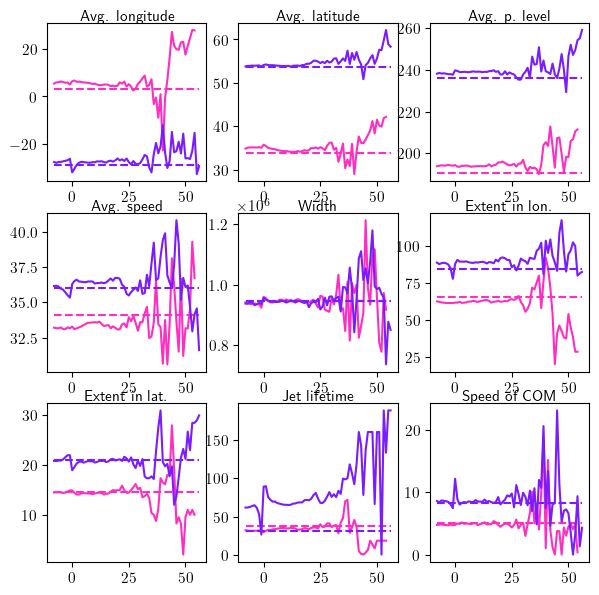

In [19]:
season = "JJA"
props_cesm = props_as_df
persistent_spells = get_persistent_jet_spells(props_cesm, "persistence", "EDJ", season=season, minlen=2)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = extract_season_from_df(props_cesm, season).group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
fig.savefig(f"{FIGURES}/future_persistent_spells/pers_EDJ")

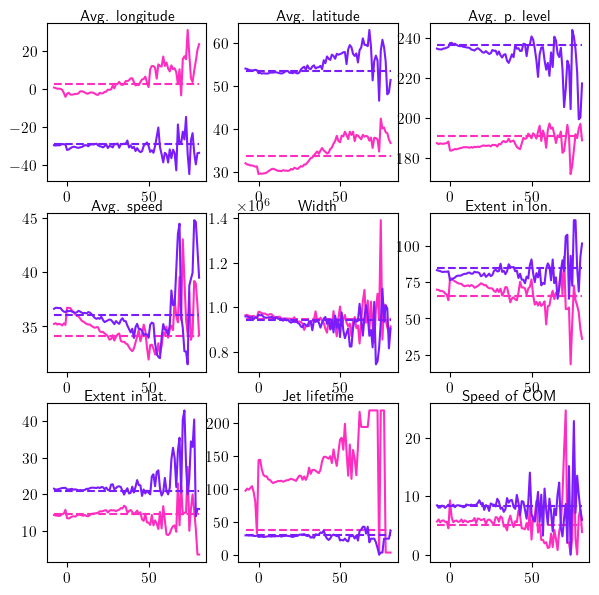

In [20]:
season = "JJA"
persistent_spells = get_persistent_jet_spells(props_cesm, "persistence", "STJ", season=season, minlen=2)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = extract_season_from_df(props_cesm, season).group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
fig.savefig(f"{FIGURES}/future_persistent_spells/pers_STJ")

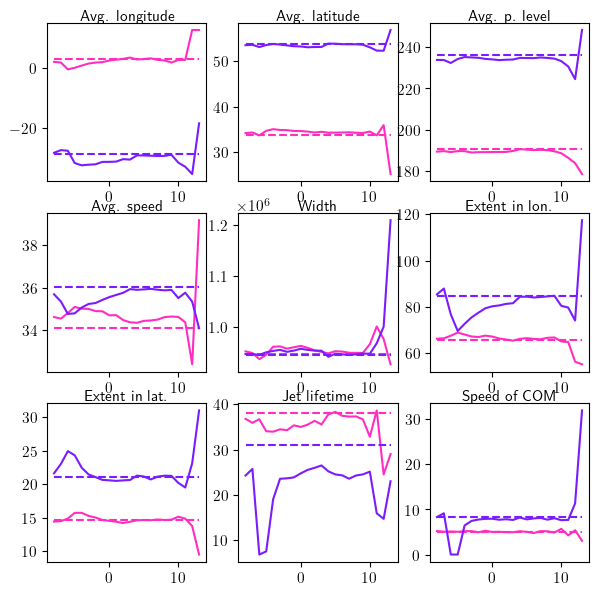

In [21]:
season = "JJA"
persistent_spells = get_persistent_jet_spells(props_cesm, "com_speed", "EDJ", season=season, minlen=2, q=0.1)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
means = extract_season_from_df(props_cesm, season).group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
fig.savefig(f"{FIGURES}/future_persistent_spells/com_speed_EDJ")

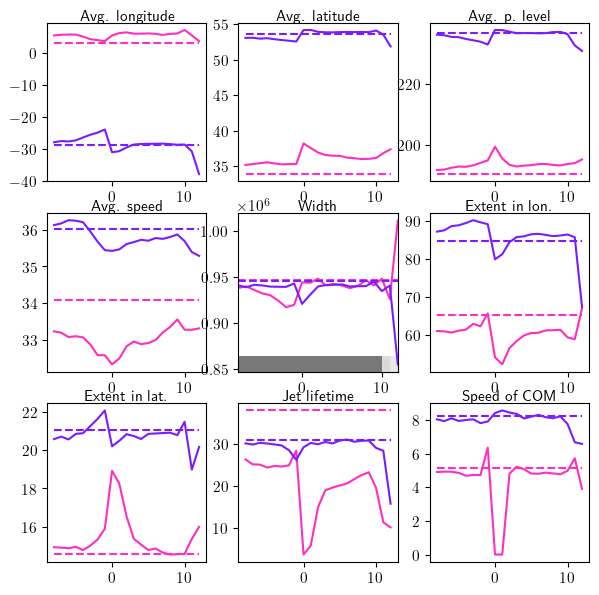

In [22]:
season = "JJA"
persistent_spells = get_persistent_jet_spells(props_cesm, "com_speed", "STJ", season=season, minlen=2, q=0.15)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
mean_ps = persistent_spells.group_by(["relative_index", "jet"], maintain_order=True).agg(**aggs)
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
x = mean_ps["relative_index"].unique().to_numpy()
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    "mod_grey", 
    cmap(np.linspace(0.1, 0.73, 200)), N=200
)
norm = BoundaryNorm(MaxNLocator(200).tick_values(0, mean_ps["alive"].max()), cmap.N)
positive_mask = x.astype(int) > 0
means = extract_season_from_df(props_cesm, season).group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    alive = to_plot["alive"].to_numpy()
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 1:
            ax.set_title(PRETTIER_VARNAME[data_var])
        if data_var == "width" and j==1:
            ylim = ax.get_ylim()
            ybounds = ylim[0] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
            im = ax.pcolormesh(
                x.astype(float), ybounds, alive[None, :-1], zorder=-10, norm=norm,
                cmap=cmap, alpha=0.7
            )
fig.savefig(f"{FIGURES}/future_persistent_spells/com_speed_STJ")

## persistence from SOMs

In [25]:
import datetime
from functools import partial


def get_spells_sigma(df: pl.DataFrame, dists: np.ndarray, sigma: int = 1) -> pl.DataFrame:
    start = 0
    spells = []
    while True:
        start_lab = df[int(start), "labels"]
        next_distance_cond = dists[start_lab, df[start:, "labels"]] > sigma
        if not any(next_distance_cond):
            spells.append({"rel_start": start, "value": start_lab, "len": len(df[start:, "labels"])})
            break
        to_next = np.argmax(next_distance_cond)
        spells.append({"rel_start": start, "value": start_lab, "len": to_next})
        start = start + to_next
    return pl.DataFrame(spells).with_columns(year=df[0, "year"], my_len=df.shape[0])


def get_persistent_spell_times_from_som_(
    labels_df, dists: np.ndarray, sigma: int = 0, minlen: int = 4, nt_before: int = 0, nt_after: int = 0, nojune: bool = True, daily: bool = False,
):  
    labels_df = labels_df.with_columns(pl.col("time").dt.year().alias("year"))
    index_columns = get_index_columns(labels_df)
    index = labels_df[index_columns].unique(maintain_order=True)

    out = labels_df.group_by("year", maintain_order=True).map_groups(partial(get_spells_sigma, dists=dists, sigma=sigma))
    out = out.with_columns(start = pl.col("year").rle_id() * pl.col("my_len") + pl.col("rel_start"))
    out = out.with_columns(
        range=pl.int_ranges(
            pl.col("start") - nt_before, pl.col("start") + pl.col("len") + nt_after
        ),
        relative_index=pl.int_ranges(-nt_before, pl.col("len") + nt_after, dtype=pl.Int16),
    )
    out = out.with_row_index("spell").explode(["range", "relative_index"])
    out = out.filter(pl.col("range") < len(index), pl.col("range") >= 0)
    out = out.with_columns(index[out["range"]])
    out = out.filter(pl.col("len") >= minlen)
    out = out.with_columns(pl.col("spell").rle_id())
    out = (
        out.group_by("spell", maintain_order=True)
        .agg(
            [
                pl.col(col).filter(
                    pl.col("time").dt.year()
                    == pl.col("time")
                    .dt.year()
                    .get(pl.arg_where(pl.col("relative_index") == 0).first())
                )
                for col in ["time", "relative_index", "value"]
            ]
        )
        .explode(["time", "relative_index", "value"])
    )
    out = out.with_columns(
        out.group_by("spell", maintain_order=True)
        .agg(
            relative_time=pl.col("time")
            - pl.col("time").get(pl.arg_where(pl.col("relative_index") == 0).first())
        )
        .explode("relative_time")
    )
    if not nojune:
        return out
    june_filter = out.group_by("spell", maintain_order=True).agg(
        (pl.col("time").dt.ordinal_day() <= 160).sum() > 0.8
    )["time"]
    out = out.filter(pl.col("spell").is_in(june_filter.not_().arg_true()))
    out = out.with_columns(pl.col("spell").rle_id())

    if not daily:
        return out
    
    ratio = out.filter(pl.col("relative_index") == 1)[0, "relative_time"] / datetime.timedelta(days=1)
    out = out.with_columns(pl.col("time").dt.round("1d")).unique(["spell", "time"], maintain_order=True)
    out = out.with_columns(out.group_by("spell", maintain_order=True).agg(pl.col("relative_index").rle_id() + (pl.col("relative_index").first() * ratio).round().cast(pl.Int16)).explode("relative_index"))
    out = out.with_columns(relative_time=pl.col("relative_index") * pl.duration(days=1))
    return out


def get_persistent_spell_times_from_som(
    labels, dists: np.ndarray, sigma: int = 0, minlen: int = 4, nt_before: int = 0, nt_after: int = 0, nojune: bool = True, daily: bool = False,
):
    if "member" not in labels.columns:
        return get_persistent_spell_times_from_som_(
            labels, dists, sigma, minlen, nt_before, nt_after, nojune, daily
        )
    to_ret = []
    for member, labels_ in labels.group_by("member", maintain_order=True):
        member = member[0]
        to_ret_ = get_persistent_spell_times_from_som_(
            labels_.drop("member"), dists, sigma, minlen, nt_before, nt_after, nojune, daily
        )
        to_ret_ = to_ret_.with_columns(member=pl.lit(member))
        to_ret.append(to_ret_)
    return pl.concat(to_ret)



def mask_from_spells_pl(spells: pl.DataFrame, to_mask: xr.DataArray | xr.Dataset | pl.DataFrame):
    unique_times_spells = spells["time"].unique().to_numpy()
    unique_times_to_mask = np.unique(to_mask["time"].to_numpy())
    unique_times = np.intersect1d(unique_times_spells, unique_times_to_mask) 
    spells = spells.filter(pl.col("time").is_in(unique_times))
    if isinstance(to_mask, xr.DataArray | xr.Dataset):
        to_mask = compute(to_mask.sel(time=unique_times), progress=True)
        to_mask = xarray_to_polars(to_mask)
        index_columns_xarray = get_index_columns(to_mask, ["lat", "lon", "jet", "jet ID"])
    else:
        to_mask = to_mask.cast({"time": pl.Datetime("ns")})
        to_mask = to_mask.filter(pl.col("time").is_in(unique_times))
        index_columns_xarray = None
    to_mask = to_mask.cast({"time": pl.Datetime("ns")})
    spells = spells.cast({"time": pl.Datetime("ns")})
    index_columns = get_index_columns(to_mask, ["member", "time"])
    masked = spells.join(to_mask, on=index_columns)
    if not index_columns_xarray or masked.shape[0] == 0:
        return masked
    masked = polars_to_xarray(masked, ["spell", "relative_index", *index_columns_xarray])
    ndim = masked["time"].ndim
    indexer = [0 if i >= 2 else slice(None) for i in range(ndim)]
    masked["time"] = masked["time"][*indexer]
    indexer = [0 if i != 1 else slice(None) for i in range(ndim)]
    masked["relative_time"] = masked["relative_time"][*indexer]
    indexer = [2 if i != 0 else slice(None) for i in range(ndim)]
    masked["value"] = masked["value"][*indexer]
    masked = masked.set_coords(["time", "relative_time", "value"])
    data_vars = list(masked.data_vars)
    if len(data_vars) == 1:
        masked = masked[data_vars[0]]
    return masked

In [26]:
from sklearn.metrics import pairwise_distances
labels_df = xarray_to_polars(labels)
dists = pairwise_distances(net.weights)
sigma = np.quantile(dists[dists > 0], 0.1)
spells = get_persistent_spell_times_from_som(labels_df, dists, sigma, nt_before=5, nojune=False)

In [27]:
exp_cesm = JetFindingExperiment(DataHandler(f"{DATADIR}/CESM2/flat_wind/results/1", ds_cesm))
props_cesm = exp_cesm.props_as_df()
props_cesm_anoms = compute_anomalies_pl(props_cesm, other_index_columns=("jet", "member"), smooth_clim=15, normalize=True)

### jet indices

In [51]:
props_masked = mask_from_spells_pl(spells, props_cesm_anoms)
data_vars = ["mean_lon", "mean_lat", "mean_lev", "mean_s", "width", "lon_ext", "lat_ext", "persistence", "com_speed"]
aggs = {col: pl.col(col).mean() for col in data_vars}
aggs = aggs | {"alive": pl.col("time").len()}
props_masked_on_som = props_masked.group_by(["value", "relative_index", "jet"]).agg(**aggs).sort(["value", "relative_index", "jet"])
props_on_som = labels_df.join(props_cesm_anoms.cast({"time": labels_df["time"].dtype}), on=["time", "member"])
props_on_som = props_on_som.drop("time", "member").group_by(["labels", "jet"], maintain_order=True).mean().sort(["labels", "jet"])

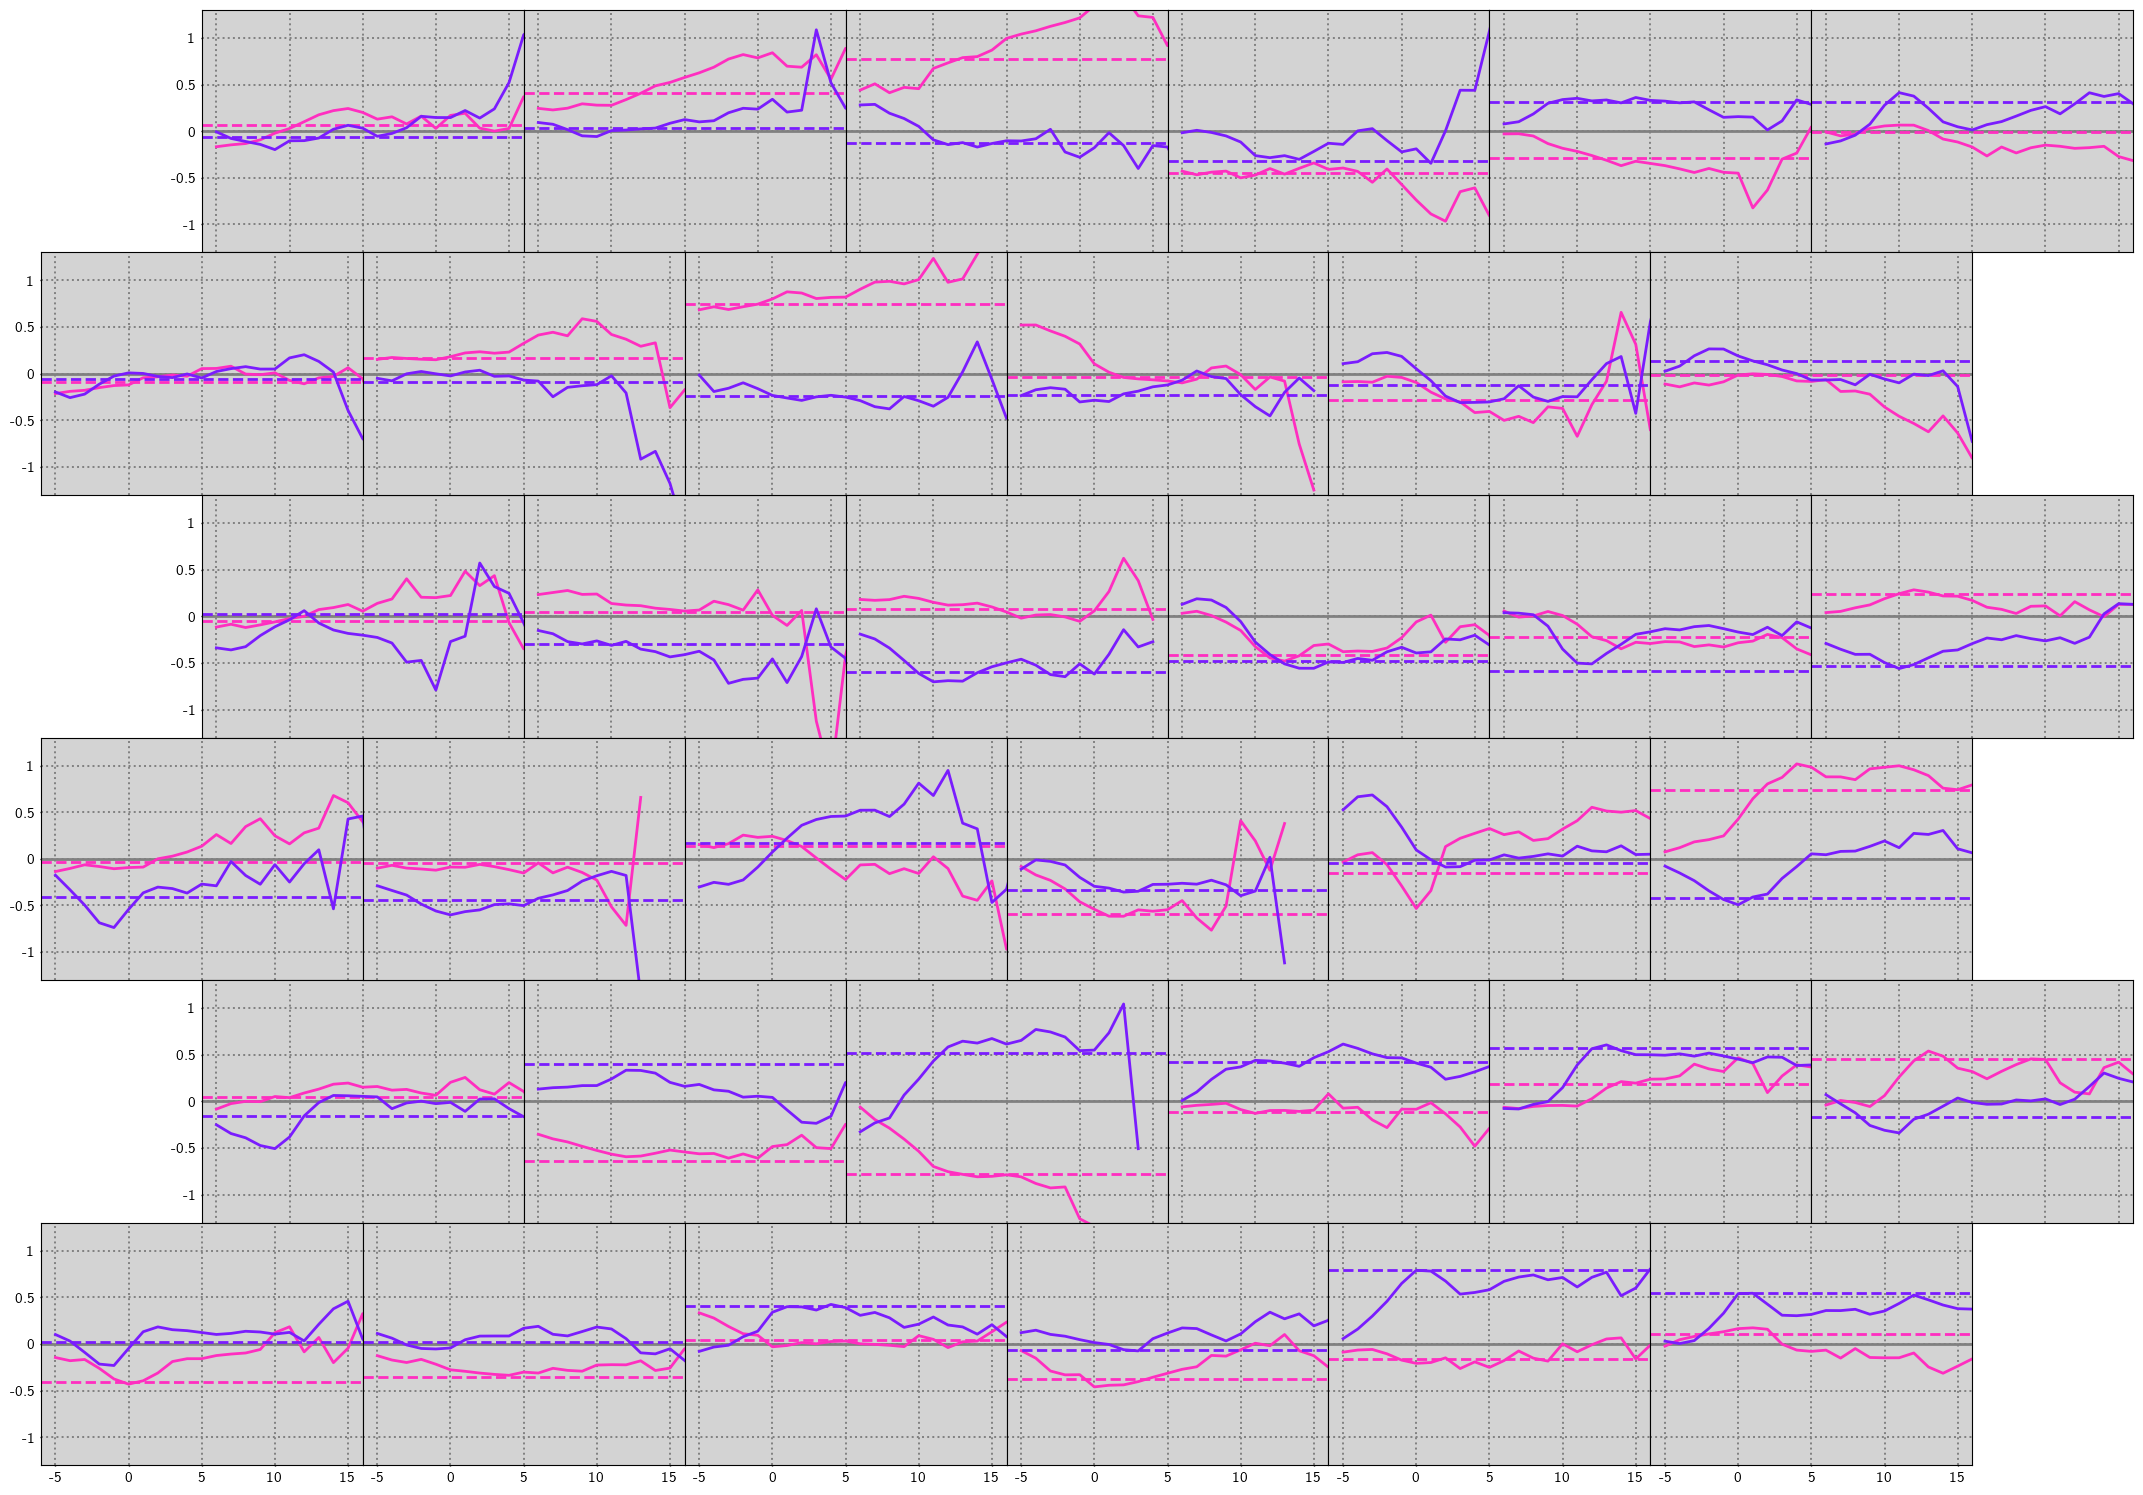

In [67]:
fig, axes = honeycomb_panel(
    6, 6, .7
)
rel_ind_ticks = [-5, 0, 5, 10, 15]
anom_ticks = [-1, -0.5, 0, 0.5, 1]
xlim = [rel_ind_ticks[0] - 1, rel_ind_ticks[-1] + 1]
ylim = [anom_ticks[0] - 0.3, anom_ticks[-1] + 0.3]
varname = "mean_s"
mean_anoms = {}
for (l, ax), (i, j) in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape))):
    ax.plot(xlim, [0, 0], color="gray", lw=2)
    for k, jet in enumerate(["STJ", "EDJ"]):
        to_plot_ = props_masked_on_som.filter(pl.col("jet") == jet, pl.col("value") == l)
        ax.plot(to_plot_["relative_index"], to_plot_[varname], color=COLORS[2 - k], lw=2)
        mean_anom = props_on_som.filter(pl.col("labels") == l, pl.col("jet") == jet)[varname]
        ax.plot(xlim, [mean_anom, mean_anom], color=COLORS[2 - k], lw=2, linestyle="dashed")
    ax.grid(linestyle="dotted", lw=1.4, color="gray")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_facecolor('lightgray')
    if i == 5:
        ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(rel_ind_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(anom_ticks, labels=anom_ticks)
        ax.tick_params(axis='y', width=1, size=1)
    else:       
        ax.set_yticks(anom_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)

In [26]:
mean_ps = persistent_spells.group_by(["relative_index", "jet"]).agg(**aggs).sort(["relative_index", "jet"])

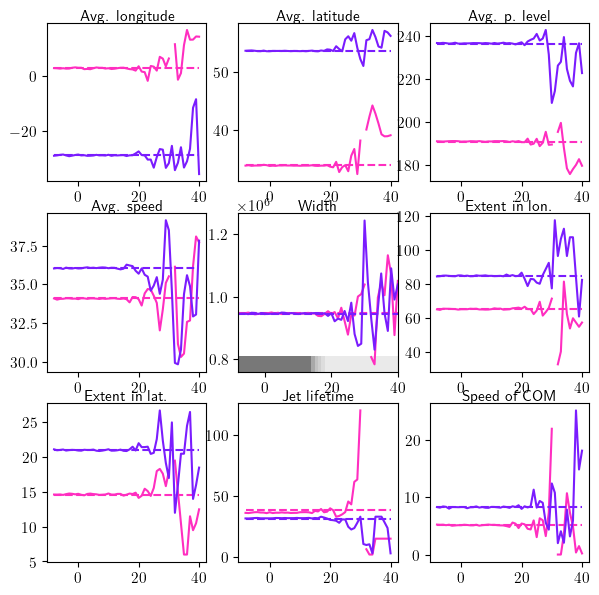

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
axes = axes.ravel()
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    "mod_grey", 
    cmap(np.linspace(0.1, 0.73, 200)), N=200
)
norm = BoundaryNorm(MaxNLocator(10).tick_values(0, mean_ps["alive"].max()), cmap.N)
x = mean_ps["relative_index"].unique().to_numpy()
positive_mask = x.astype(int) > 0
means = props_as_df_summer.group_by("jet", maintain_order=True).mean()
for j, jet in enumerate(["STJ", "EDJ"]):
    to_plot = mean_ps.filter(pl.col("jet") == jet)
    alive = to_plot["alive"].to_numpy()
    for ax, data_var in zip(axes, data_vars):
        ax.plot(x, to_plot[data_var], color=COLORS[2 - j])
        mean = means[j, data_var]
        ax.plot([x[0], x[-1]], [mean, mean], color=COLORS[2 - j], ls="dashed")
        if j == 0:
            ax.set_title(PRETTIER_VARNAME[data_var])
        if data_var == "width" and j==1:
            ylim = ax.get_ylim()
            ybounds = ylim[0] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
            im = ax.pcolormesh(
                x.astype(float), ybounds, alive[None, :-1], zorder=-10, norm=norm,
                cmap=cmap, alpha=0.7
            )
fig.savefig(f"{FIGURES}/future_persistent_spells/from_som")

### precip

In [7]:
ds_ts_past = xr.open_dataset(f"{DATADIR}/CESM2/TS/past.zarr", engine="zarr")

In [8]:
ds_ts_past = compute(ds_ts_past, progress_flag=True)

In [28]:
df_ts_past_masked = mask_from_spells_pl(spells, ds_ts_past.isel(member=0))

In [35]:
df_ts_past_masked["TS"].mean("spell")

<xarray.DataArray 'TS' (relative_index: 30, lat: 69, lon: 97)> Size: 803kB
array([[[301.0574 , 301.0781 , 301.1748 , ..., 305.7586 , 307.34192,
         306.63565],
        [301.2207 , 301.3089 , 301.49088, ..., 308.74512, 306.74673,
         304.19327],
        [301.54672, 301.68365, 301.91898, ..., 311.24484, 306.5504 ,
         303.9207 ],
        ...,
        [271.8094 , 271.31534, 271.64822, ..., 272.8627 , 272.86703,
         272.88028],
        [268.22342, 269.2991 , 269.83127, ..., 272.69482, 272.69354,
         272.70645],
        [270.30435, 269.66324, 269.6361 , ..., 272.6079 , 272.60916,
         272.619  ]],

       [[301.0601 , 301.08075, 301.17676, ..., 305.7711 , 307.35474,
         306.66013],
        [301.22275, 301.30936, 301.49115, ..., 308.81488, 306.75833,
         304.19568],
        [301.5471 , 301.6839 , 301.91885, ..., 311.38077, 306.57864,
         303.92374],
...
        [270.91568, 269.6858 , 270.2465 , ..., 273.65942, 273.6926 ,
         273.72534],
        [268.00604, 268.83218, 267.0909 , ..., 273.29794, 273.33902,
         273.38614],
        [269.80466, 269.02963, 268.5029 , ..., 273.03333, 273.07733,
         273.12888]],

       [[301.35678, 301.3517 , 301.37784, ..., 309.23428, 310.0434 ,
         306.63403],
        [301.45004, 301.52695, 301.67105, ..., 311.47192, 307.05746,
         304.1295 ],
        [301.7384 , 301.87015, 302.09366, ..., 312.12506, 305.46826,
         303.6335 ],
        ...,
        [273.058  , 272.24948, 272.5006 , ..., 272.5354 , 272.384  ,
         272.3812 ],
        [270.51105, 271.63907, 271.44998, ..., 272.38446, 272.26154,
         272.2649 ],
        [272.1362 , 271.83997, 271.81317, ..., 272.38538, 272.37808,
         272.33905]]], dtype=float32)
Coordinates:
    relative_time   (relative_index) timedelta64[ns] 240B NaT NaT ... NaT NaT
  * relative_index  (relative_index) int16 60B -5 -4 -3 -2 -1 ... 20 21 22 23 24
  * lat             (lat) float64 552B 15.55 16.49 17.43 ... 77.75 78.69 79.63
  * lon             (lon) float64 776B -80.0 -78.75 -77.5 ... 37.5 38.75 40.0